In [1]:
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (6, 6)

import math
import cmath          # math functions for complex numbers
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

import scipy
import scipy.stats
import pandas as pd

from astropy.io import fits
import os.path

import ipywidgets
from ipywidgets import interact

import sys
sys.path.append("/Users/jdecock/git/pub/jdhp-sap/sap-cta-data-pipeline/datapipe")
import datapipe
import datapipe.denoising.wavelets_mrfilter as mrfilter
sys.path.append("/Users/jdecock/git/pub/jdhp-sap/sap-cta-data-pipeline/utils")
import common_functions as common

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/pytz/__init__.py:29: UserWarning: Module argparse was already imported from /Users/jdecock/anaconda/envs/cta/lib/python3.5/argparse.py, but /Users/jdecock/.local/lib/python3.5/site-packages/argparse-1.1-py3.5.egg is being added to sys.path
  from pkg_resources import resource_stream
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)


### GUI

In [ ]:
file_path_list = [
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV00507.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV01909.fits"
    ]

In [ ]:
# gamma 10000 - 50000 (electronic saturation!)
file_path_list = [
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL033_EV131901.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL012_EV131903.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL030_EV131907.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL030_EV131908.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL031_EV311808.fits"
    ]

In [ ]:
# gamma 1000 - 10000
file_path_list = [
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV126402.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV131305.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV182506.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV225002.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV26603.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV458108.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV483109.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV62605.fits"
    ]

In [3]:
# gamma 50 - 1000

file_path_list = [
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV155601.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV193406.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV347307.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV427404.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV450207.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV454807.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV48104.fits",
    "/Users/jdecock/data/astri_mini_array/fits/gamma/run1001.simtel.gz_TEL001_EV58000.fits"
    ]

In [5]:
# mr_filter options

option_list = [
    "-K -C1 -m3  -s4 -n4 -t24 -f3",           # Suggested by Jean-Luc (TODO: try to adapt -s)
#    "-K -C1 -m3  -s5 -n4 -t28 -f3 -i10 -e0",  # Suggested by Jean-Luc (TODO: try to adapt -s)
    "-K -C1 -m3  -s3 -n4",      # Hard K-Sigma Thresholding, Poisson + Gaussian
    "-K -C1 -m3  -s3 -n4 -f3",
#    "-K -C1 -m3  -s2,2,3,3 -n4 -f3",
    "-K -C1 -m3  -s2,2,3,3 -n4",
#    "-K -C1 -m3  -s3 -n4 -f2",  # Soft K-Sigma Thresholding, Poisson + Gaussian (deconseille par JL)
#    "-K -C2 -m1      -n4 -f2",  # False Discovery Rate
#    "-K     -m1      -n4 -f6",  # Wiener Filtering (min MSE between random process and desired process)
#    "-K -C1 -m10 -s3 -n4",      # Poisson with few events
#    "-K -C1 -m2  -s3 -n4",      # Poisson
    ]

In [ ]:
!mr_filter -h


mr_filter -K -C1 -m3  -s4 -n4 -t24 -f3 ".tmp_93252_1488206203.389623_in.fits" .tmp_93252_1488206203.389632_out.fits
Kill isolated pixels


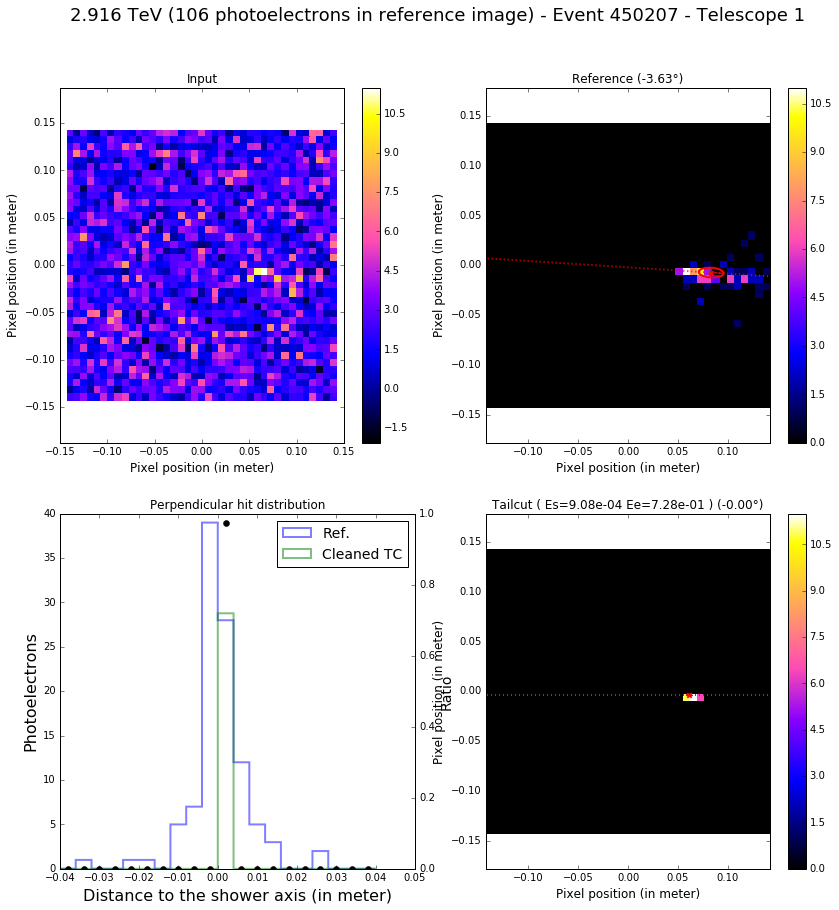

In [6]:
@interact(kill_pix=True, hist=False, log_scale=True, ellipses=True, lateral_hst=["Wavelet", "Tailcut", None], ref_angle=False, file_path=file_path_list, mrfilter=option_list)
def gui(kill_pix, hist, log_scale, ellipses, lateral_hst, ref_angle, file_path, mrfilter):
    fits_images_dict, fits_metadata_dict = datapipe.io.images.load_benchmark_images(file_path)
    input_img = fits_images_dict["input_image"]
    reference_img = fits_images_dict["reference_image"]
    pixels_position = fits_images_dict["pixels_position"]

    fig = plt.figure(figsize=(14, 14))

    common.plot_gui(fig,
                    input_img,
                    reference_img,
                    pixels_position,
                    fits_metadata_dict,
                    wavelets_cmd=mrfilter,
                    kill_isolated_pixels=kill_pix,
                    plot_histogram=hist,
                    plot_log_scale=log_scale,
                    plot_ellipse_shower=ellipses,
                    _plot_perpendicular_hit_distribution=lateral_hst,  # None, "Tailcut", "Wavelet"
                    use_ref_angle_for_perpendicular_hit_distribution=ref_angle,
                    notebook=True
                   )